# Time Series Forecasting - forecasting Cognizant sales

In this notebook, I will use time series forecasting to forecast champagne sales.

Monthly sales are given in millions for 12 years. I have taken the sales values of the last year as the test data, and the data before that as the test data. I will build ARIMA and SARIMA models for this data.

The procedure is as follows:-

1. Import the dataset.
2. Build train and test set.
3. Check stationarity in data.
4. Make data stationary.
5. Build models.
6. Validate the model with test set.

Importing the required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

## Import the dataset

In [11]:
df = pd.read_excel('champagne.xlsx', skiprows=12, names = ['Month', 'Sales'], parse_cols = 1)

In [12]:
df.head()

,Month,Sales
0,2010-01-01,2815
1,2010-02-01,2672
2,2010-03-01,2755
3,2010-04-01,2721
4,2010-05-01,2946


To convert the data frame into a time series I take the 'Month' column and convert it into the index of the series. 

In [13]:
df.index = pd.to_datetime(df['Month'],format='%y-%m')
df.head()

,Month,Sales
Month,,
2010-01-01,2010-01-01,2815
2010-02-01,2010-02-01,2672
2010-03-01,2010-03-01,2755
2010-04-01,2010-04-01,2721
2010-05-01,2010-05-01,2946


## Build train and test sets

Taking the values of all the years except 1972 as the train data and the values in the year 1972(9 months) as the test data

In [14]:
ts_train = df[df.index.year != 2018]['Sales']
ts_test = df[df.index.year == 2018]['Sales']

print('train examples: ', ts_train.shape[0])
print('test examples: ', ts_test.shape[0])

train examples:  96
test examples:  9


In [15]:
ts_train.head()

Month
2010-01-01    2815
2010-02-01    2672
2010-03-01    2755
2010-04-01    2721
2010-05-01    2946
Name: Sales, dtype: int64

The index of the series corresponds to the monthly dates

In [16]:
ts_train.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01',
               '2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
      

## Time series plot and stationarity

Let us plot the time series for an initial analysis.

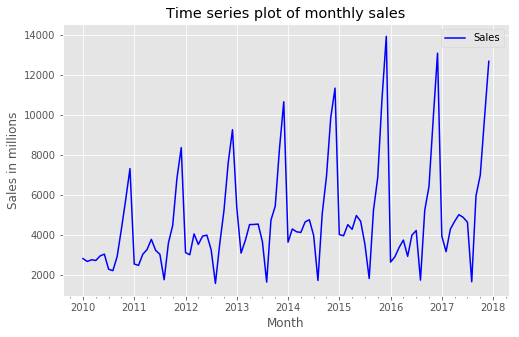

In [17]:
ts_train.plot(figsize=(8, 5), color= 'blue')
plt.legend()
plt.ylabel('Sales in millions')
plt.title('Time series plot of monthly sales')
plt.show()

We can see that there is seasonality in the data, with the peaks repeating themselves. Also the peaks are getting higher and higher every year.

Let us decompose the plot into trend, seasonality and residuals.

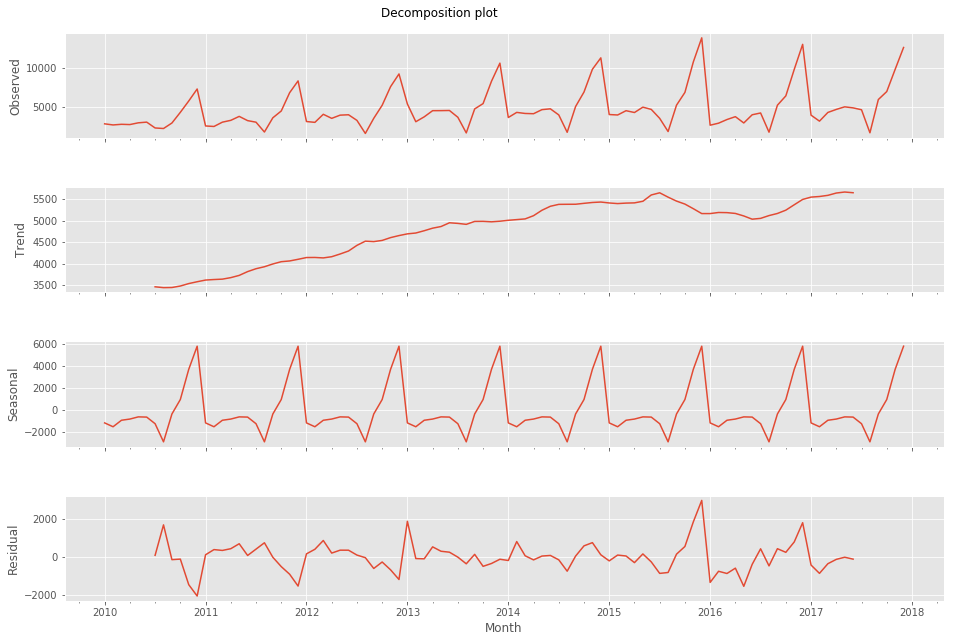

In [19]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(ts_train, model='additive', freq = 12)
fig = decomposition.plot()
fig.set_size_inches(15,10)
fig.suptitle('Decomposition plot')
plt.show()

We can clearly see the seasonality in the data. There looks like there is some trend as well. The residual is also not at all constant. We want to make the series stationary. We can check the stationarity by using the rolling mean as well as using the Dicky Fuller hypothesis test.

The Dicky Fuller test assumes in the null hypothesis that the series is non-stationary. If the test statistic is less than the critical value then the null is rejected and the series is staitonary, else the series is non statonary and we need to use transformations to make the series stationary.

I define some functions to plot the rolling mean and the rolling standard deviation, as well as to perform the Dicky Fuller Test.

In [20]:
def make_plot(series,window, title = ''):
    rollmean = series.rolling(window=12).mean()
    rollstd = series.rolling(window =12).std()
    plt.figure(figsize = (8,5))
    series.plot()
    rollmean.plot(label = 'rolling mean')
    rollstd.plot(label = 'rolling std')
    plt.ylabel('Sales in millions')
    plt.title(title)
    plt.legend()
    plt.show()

In [21]:
from statsmodels.tsa.stattools import adfuller
def dfuller(series):
    dftest = adfuller(series, autolag='AIC')
    values_names = ['Test Statistic','p-value','no. of lags Used','Number of Observations Used']
    for value_name,value in list(zip(values_names,dftest)):
        print(value_name,': ', value)
    print('critical values: ',dftest[4])

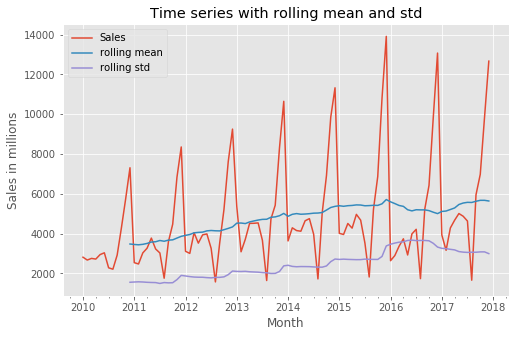

In [22]:
make_plot(ts_train, 12, 'Time series with rolling mean and std')

The plot shows that the rolling mean as well as the standard deviation is not constant, this gives us a hint of non-stationarity. Let us confirm it by using the Dicky Fuller Test.

In [23]:
dfuller(ts_train)

Test Statistic :  -1.62055677583
p-value :  0.472437413624
no. of lags Used :  11
Number of Observations Used :  84
critical values:  {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}


The test shows that the test statistic is greater than the 1% value. This shows that we cannot reject the null hypothesis and the series is non-stationary.

Now we will make the series stationary. Since the series has seasonality which is quite clearly visible, we can remove the seasonality by shifting the series by 12 and subtracting it from the orignal series.

dftest = adfuller(ts_log_diff, autolag='AIC')
values_names = ['Test Statistic','p-value','no. of lags Used','Number of Observations Used']
for value_name,value in list(zip(values_names,dftest)):
    print(value_name,': ', value)
print(dftest[4])

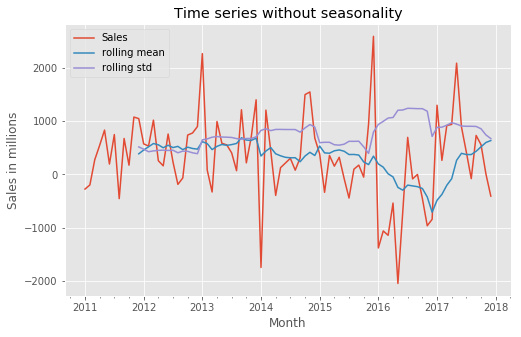

In [24]:
seasonal_diff_ts = ts_train - ts_train.shift(12)
seasonal_diff_ts.dropna(inplace  =True)
make_plot(seasonal_diff_ts,12, 'Time series without seasonality')


We can see that the seasonality has been removed from the time series. Let us perform the Dicky Fullet Test now to see if the time series is stationary now.

In [25]:
dfuller(seasonal_diff_ts)

Test Statistic :  -7.21820647748
p-value :  2.14534547149e-10
no. of lags Used :  0
Number of Observations Used :  83
critical values:  {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}


We can see that the time series is now stationary, as the test statistic is much less than the 1 percent critical value. This means that we are more than 99% confident that the time series is stationary.

Now that we have removed the stationarity from our time series, we can make the ACF(Auto-correlation function) and PACF(Partial Auto-correlation function) plots which will help us decide the parameters of our Arima model.

In [26]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [27]:
ts_acf = acf(seasonal_diff_ts,nlags=40)
ts_pacf = pacf(seasonal_diff_ts,nlags =40)

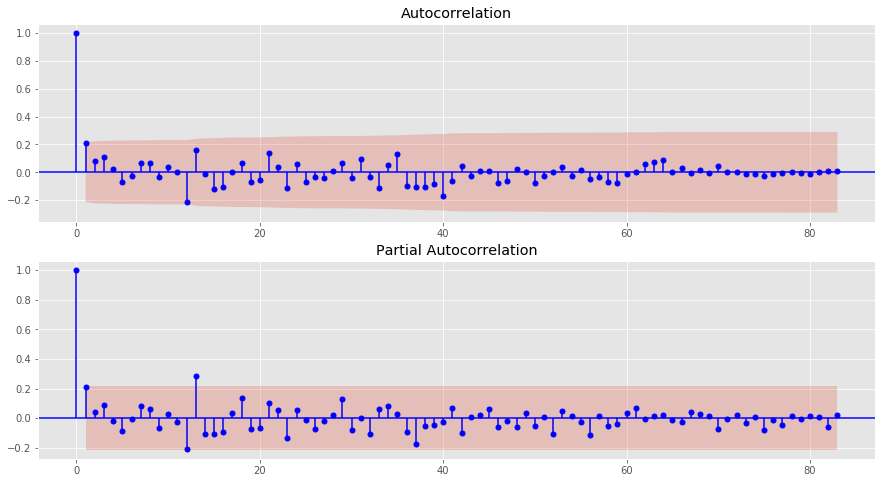

In [28]:
plt.figure(figsize = (15,8))
plt.subplot(211)
plot_acf(seasonal_diff_ts, ax=plt.gca(), color ='blue')
plt.subplot(212)
plot_pacf(seasonal_diff_ts, ax=plt.gca(),  color ='blue')
plt.show()

As you can see, that there are only a few significant values in both the ACF and the PACF. Both the PACF and ACF drop off suddenly, perhaps suggesting a mix of AR and MA models. All this is insignificant for us as we will try a bunch of different parameters and choose the one with lower RMSE(root mean square error). 

We define a function to take the seasonal difference for a series to remove the seasonality.

As the model will predict values for non-seasonal data we need to add back the seasonal components we subtracted to get the true predictions. We define a function called inverse_seas_diff to inverse the seasonal difference of the series.

In [29]:
def inverse_seas_diff(original, value, interval):
    return value + original.iloc[-interval]

def make_seas_diff(original, interval):
    seasonal_diff_ts = original - original.shift(interval)
    seasonal_diff_ts.dropna(inplace  =True)
    return list(seasonal_diff_ts)


## Building models

We will now build our ARIMA model. First we import the required class.

In [30]:
from statsmodels.tsa.arima_model import ARIMA

The method we will use is feed forward validation. How this works is that we will build a model by iterating over every value in the test set. For every value in the test set-

1. We will take the train set and remove its seasonality.
2. Build a model using the non-stationary data.
3. Forecast the next value using the model.
4. Add the true value to the train set.
5. Add the predicted value to the predictions list.
6. Go to step 1.

At the end we will find the rmse, using the predictions and the test set.

In [31]:
def rmse(order):
    
    train_list = list(ts_train)
    predictions = []
    for index,true_value in ts_test.iteritems(): 
        seasonal_diff_ts = make_seas_diff(pd.Series(train_list),12)
        model = ARIMA(seasonal_diff_ts, order=order)
        results_AR = model.fit(trend = 'nc',disp=0)
        pred = results_AR.forecast()[0][0]
        pred = inverse_seas_diff(pd.Series(train_list),pred,12)
        train_list.append(true_value)
        predictions.append(pred)

    return ('RMSE: ', mean_squared_error(list(ts_test), predictions) ** 0.5)


We will try all possible combinations of parameters for (p,d,q) and then compute rmses for each combination. For some of the combinations the underlying code in the library will give errors due to mathematical operations. We will skip those.

In [32]:
import itertools
p = range(0,5)
d = range(0,3)
q = range(0,5)
combinations = list(itertools.product(p,d,q))

for parameter in combinations:
    try:
        order = parameter
        print(order,':', rmse(order))
    except:
        continue
        

(0, 1, 1) : ('RMSE: ', 350.79735149356395)
(0, 1, 2) : ('RMSE: ', 360.37150348105013)
(0, 2, 1) : ('RMSE: ', 504.43488935106586)
(1, 1, 0) : ('RMSE: ', 421.25622453489069)
(1, 1, 1) : ('RMSE: ', 363.48136879909077)
(1, 1, 2) : ('RMSE: ', 366.1887752728054)
(1, 1, 3) : ('RMSE: ', 364.98310788635411)
(1, 2, 0) : ('RMSE: ', 711.95248649787607)
(2, 1, 0) : ('RMSE: ', 370.77754033217616)
(2, 1, 1) : ('RMSE: ', 372.18114117897744)
(2, 1, 3) : ('RMSE: ', 331.68716912675058)
(2, 2, 0) : ('RMSE: ', 614.0127184830809)


C:\Users\AI\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 2, 1) : ('RMSE: ', 372.06789267066318)
(3, 1, 0) : ('RMSE: ', 348.13951489344817)
(3, 1, 1) : ('RMSE: ', 364.97134596867988)
(3, 1, 2) : ('RMSE: ', 365.45149496336546)
(3, 2, 0) : ('RMSE: ', 534.55576750786747)
(3, 2, 1) : ('RMSE: ', 350.27092146198032)


C:\Users\AI\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(4, 1, 0) : ('RMSE: ', 337.3632757104192)
(4, 1, 1) : ('RMSE: ', 366.22867152095347)
(4, 1, 2) : ('RMSE: ', 344.02436866433902)


C:\Users\AI\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\AI\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\AI\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\AI\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\AI\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", 

(4, 1, 3) : ('RMSE: ', 506.1439373620014)
(4, 2, 0) : ('RMSE: ', 451.71646637140094)
(4, 2, 1) : ('RMSE: ', 340.71417459713768)


As you can see there are a lot of models we can shoose from. Generally we can see that if there are no MA or q terms the RMSE becomes high. Let us build a model with p =0, d=1, q =1

RMSE:  350.797351494


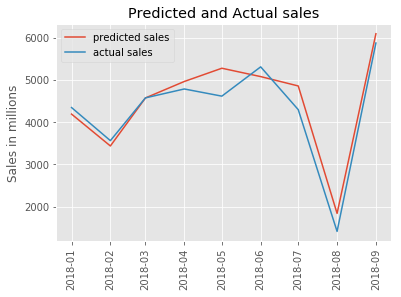

In [33]:
train_list = list(ts_train)
predictions = []
for index,true_value in ts_test.iteritems(): 
    seasonal_diff_ts = make_seas_diff(pd.Series(train_list),12)
    model = ARIMA(seasonal_diff_ts, order= (0,1,1))
    results_AR = model.fit(trend = 'nc',disp=0)
    pred = results_AR.forecast()[0][0]
    pred = inverse_seas_diff(pd.Series(train_list),pred,12)
    train_list.append(true_value)
    predictions.append(pred)

print ('RMSE: ', mean_squared_error(list(ts_test), predictions) ** 0.5)

pred_series =  pd.Series(predictions, index = ts_test.index)
plt.plot(pred_series, label = 'predicted sales')
plt.plot(ts_test, label = 'actual sales')
plt.xticks(rotation = 'vertical')
plt.ylabel('Sales in millions')
plt.title('Predicted and Actual sales')
plt.legend()

By plotting the actual and predicted values for the last 9 months in the test set we can see that the predicted sales match the actual sales in the last 9 months quite well.

Let us go a step ahead and build a Seasonal-ARIMA or SARIMA model. In this model we specify additional parameters (P,D,Q,m) for modelling the seasonality along with the general parameters (p,d,q). 'm' stands for the number of periods for which the seasonality exists.

As we are building a seasonal-ARIMA model we don't need to remove the seasonality. Let us choose P=0, D=1, Q=1 and m is 12.

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

RMSE:  328.880660631


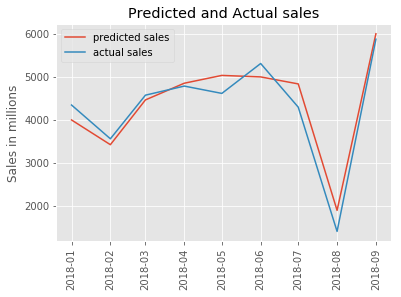

In [35]:
train_list = list(ts_train)
predictions = []
for index,true_value in ts_test.iteritems(): 
    model = SARIMAX(train_list, trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
    results_AR = model.fit(trend = 'nc',disp=0)
    pred = results_AR.forecast()[0]
    train_list.append(true_value)
    predictions.append(pred)

print ('RMSE: ', mean_squared_error(list(ts_test), predictions) ** 0.5)

pred_series =  pd.Series(predictions, index = ts_test.index)
plt.plot(pred_series, label = 'predicted sales')
plt.plot(ts_test, label = 'actual sales')
plt.xticks(rotation = 'vertical')
plt.ylabel('Sales in millions')
plt.title('Predicted and Actual sales')
plt.legend()

As we can see that the RMSE is lower than the ARIMA model and the plot also shows that the predicted and actual sales match upto quite an extent.